## Segmentation

* https://paper.dropbox.com/doc/Segmentation-RpcEF8PYcnEjbW35LP41a

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *
from matplotlib.pyplot import Rectangle

## Data

In [50]:
DATA_DIR = '../data/'
json_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.json')
img_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.png')
IMG_DIR = os.path.join(DATA_DIR, 'volleyball', 'images_subset')
metadata_fpath = os.path.join(DATA_DIR, 'volleyball_bbox_labels.csv')
FIGSIZE = (6,8)

## Helpers

In [72]:
def plot_img(arr, fs=FIGSIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.imshow(arr, cmap=cmap)
    plt.title(title)
    plt.show()
    
def load_img(fpath):
    return plt.imread(fpath)

def load_cv2_img(fpath, w=None, h=None, colorspace=None):
    img = cv2.imread(img_fpath)
    if colorspace is not None:
        img = cv2.cvtColor(img, colorspace)
    if None not in [w,h]:
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_CUBIC)
    return img

def threshold_color(img, color, thresh, sigma=1.0):
    """
    color = [b, g, r] or [r,b,g] or [h,s,v]
    thresh = [b,g,r] margin allowed around color (1 per channel)
    """
    if isinstance(thresh, int):
        thresh = [thresh]*3
    thresh = np.array(thresh) * sigma
    min_color = np.array([color[0]-thresh[0], color[1]-thresh[1], 
                          color[2]-thresh[2]])
    max_color = np.array([color[0]+thresh[0], color[1]+thresh[1],
                          color[2]+thresh[2]])
    min_color[min_color < 0] = 0
    max_color[max_color > 255] = 255
    print("Min", min_color)
    print("Max", max_color)
    
    mask = cv2.inRange(img, min_color, max_color)
    result = cv2.bitwise_and(img, img, mask=mask)
    return mask, result

def get_color_of_pixel(fpath, x, y, colorspace='BGR'):
    rgb_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
    hsv_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2HSV)
    
    rgb_colors = rgb_img[y,x,:]
    hsv_colors = hsv_img[y,x,:]
    bgr_colors = np.copy(rgb_colors[::-1])
    print ("BGR:", bgr_colors)
    print ("RGB:", rgb_colors)
    print ("HSV:", hsv_colors)
    
    # Plot to visualize
    img = np.copy(rgb_img)
    img[y-5:y+5:,x-5:x+5,:] = 255
    img[y,x,:] = 0
    
    if colorspace == 'BGR':
        return bgr_colors.tolist()
    if colorspace == 'RGB':
        return rgb_colors.tolist()
    return hsv_colors.tolist()

def get_hsv_value_of_bgr(bgr_color):
    print("BGR", bgr_color)
    bgr_color = np.uint8([[bgr_color]])
    hsv = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2HSV)[0][0]
    print("HSV", hsv)
    return hsv

# Create color histograms representing average values among samples
def get_flattened_channels(imgs):
    chans = np.empty(shape=(1,3))
    for img in imgs:
        h,w,c = img.shape
        reshaped = img.reshape((h*w, c))
        chans = np.concatenate([chans, reshaped], axis=0)
        #print(reshaped.shape, chans.shape)
    return chans

# Plotting Histogram (all channels flattened)
def plot_hist(img, bins=256, title=None):
    plt.hist(img.ravel(), bins=bins, range=[0,256])
    plt.title(title)
    plt.show()

def plot_bgr_hist(bgr_img, bins=256, mask=None):
    # Mask let's you select for certain regions    
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([bgr_img],[i],mask,[bins],[0,256])
        plt.plot(histr, color=col)
        plt.xlim([0,bins])
    plt.show()
    
def plot_bbs_from_rectLabel_annos(json_fpath, img_fpath):
    bb_json = json.load(open(json_fpath, 'r'))
    fig = plt.figure(figsize=FIGSIZE)
    axes = plt.axes([0, 0.03, 1, 0.97])
    
    img = plt.imread(img_fpath)
    imgplot = axes.imshow(img)

    for box in bb_json['objects']:
        label = box['label']
        color = BOX_COLORS[label]
        coords = box['x_y_w_h']
        bb = Rectangle(
            (coords[0],coords[1]), 
            coords[2], coords[3],
            fill=False,
            edgecolor=color,
            linewidth=2)
        axes.add_patch(bb)
        
def get_img_crops_from_rectLabel_bbs(img, json_fpath):
    crops_dict = {}
    bb_json = json.load(open(json_fpath, 'r'))
    for box in bb_json['objects']:
        label = box['label']
        x,y,w,h = box['x_y_w_h']
        crop = img[y:y+h,x:x+w,:]
        if label not in crops_dict:
            crops_dict[label] = []
        crops_dict[label].append(crop)
    return crops_dict

## Color Histograms

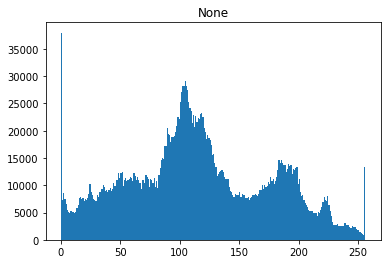

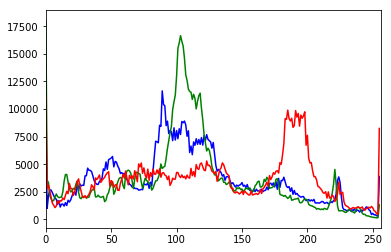

In [52]:
bgr_img = load_cv2_img(img_fpath)

# Cv2 Histogram (faster)
hist = cv2.calcHist(images=[bgr_img], channels=[0], mask=None, histSize=[256], ranges=[0,256])

# Numpy Histogram (slower)
hist, bins = np.histogram(bgr_img.ravel(), 256, [0,256])

plot_hist(bgr_img)
plot_bgr_hist(bgr_img)

## BGR Thresholding

BGR: [ 93 104 199]
RGB: [199 104  93]
HSV: [  3 136 199]
[93, 104, 199]
Min [  58.   69.  164.]
Max [ 128.  139.  234.]


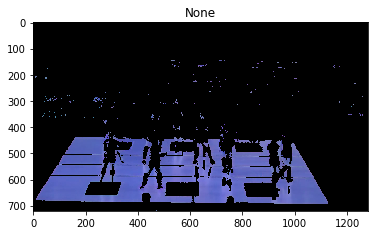

In [53]:
# Highlight the court
bgr_color = get_color_of_pixel(img_fpath, 700, 650, 'BGR')
bgr_img = load_cv2_img(img_fpath)
print(bgr_color)
mask, result = threshold_color(bgr_img, bgr_color, 35)
plot_img(result)

BGR: [130 119  55]
RGB: [ 55 119 130]
HSV: [ 94 147 130]
Min [ 70.  59.   0.]
Max [ 190.  179.  115.]


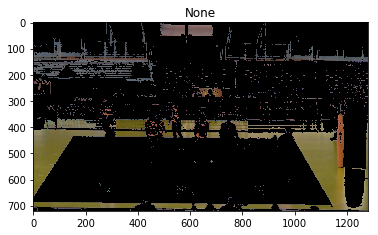

In [54]:
# Highlight floor around court (darker green)
bgr_color = get_color_of_pixel(img_fpath, 1100, 550, 'BGR')
bgr_img = load_cv2_img(img_fpath)
mask1, result1 = threshold_color(bgr_img, bgr_color, 60)
plot_img(result1)

BGR: [137 127  79]
RGB: [ 79 127 137]
HSV: [ 95 108 137]
Min [ 87.  77.  29.]
Max [ 187.  177.  129.]


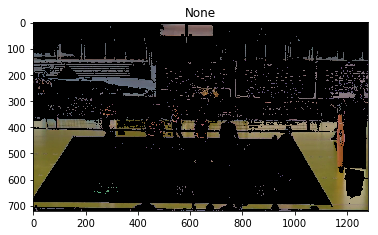

In [55]:
# Highlight floor around court (lighter green reflection)
bgr_color = get_color_of_pixel(img_fpath, 1130, 460, 'BGR')
bgr_img = load_cv2_img(img_fpath)
mask2, result2 = threshold_color(bgr_img, bgr_color, 50)
plot_img(result2)

### HSV Thresholding

BGR: [ 93 104 199]
RGB: [199 104  93]
HSV: [  3 136 199]
Min [   0.  101.  164.]
Max [  38.  171.  234.]


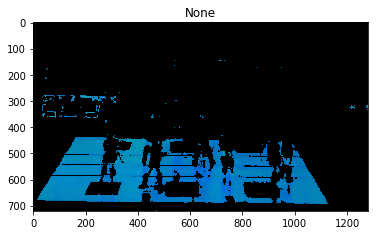

In [56]:
hsv_color = get_color_of_pixel(img_fpath, 700, 650, 'HSV')
hsv_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2HSV)
mask, result = threshold_color(hsv_img, hsv_color, 35)
plot_img(result)

BGR: [137 127  79]
RGB: [ 79 127 137]
HSV: [ 95 108 137]
Min [ 40.  53.  82.]
Max [ 150.  163.  192.]


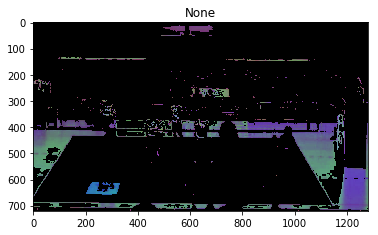

In [57]:
hsv_color = get_color_of_pixel(img_fpath, 1130, 460, 'HSV')
hsv_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2HSV)
mask, result = threshold_color(hsv_img, hsv_color, 55)
plot_img(result)

BGR: [129 120  51]
RGB: [ 51 120 129]
HSV: [ 93 154 129]
Min [ 38.  99.  74.]
Max [ 148.  209.  184.]


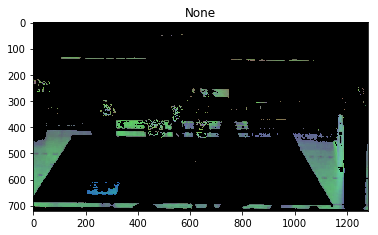

In [58]:
hsv_color = get_color_of_pixel(img_fpath, 25, 550, 'HSV')
hsv_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2HSV)
mask, result = threshold_color(hsv_img, hsv_color, 55)
plot_img(result)

## Data Driven Thresholding

* https://gist.github.com/danielballan/ab5e28420ba1b24c5ad4

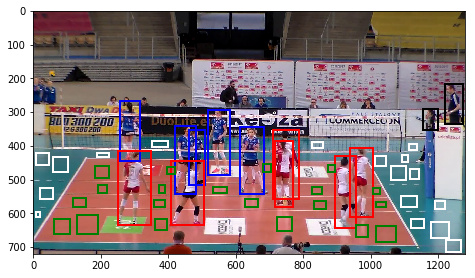

In [73]:
json_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.json')
img_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.png')

BOX_COLORS = {
    'referee': 'black',
    'red_team': 'red',
    'blue_team': 'blue',
    'court-inner': 'green',
    'court_outer': 'white',
}

plot_bbs_from_rectLabel_annos(json_fpath, img_fpath)

In [74]:
bgr_img = load_cv2_img(img_fpath)
crops = get_img_crops_from_rectLabel_bbs(bgr_img, json_fpath)

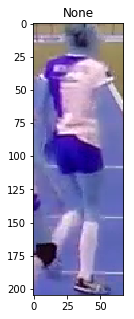

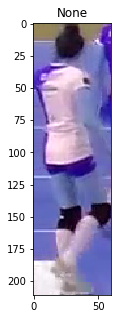

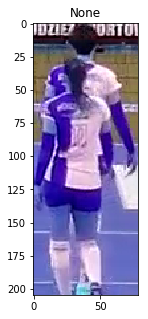

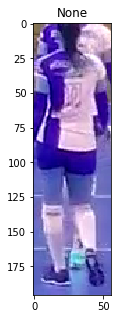

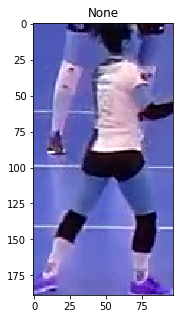

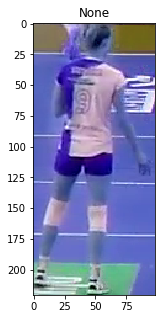

In [77]:
for crop in crops['red_team']:
    plot_img(crop, fs=(5,5))

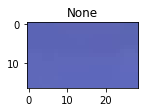

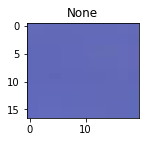

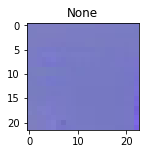

In [79]:
for crop in crops['court-inner'][:3]:
    plot_img(crop, fs=(2,2))

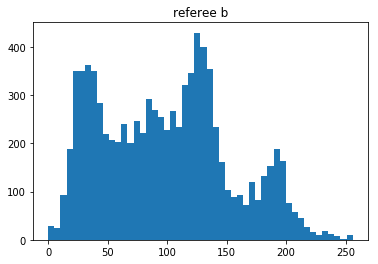

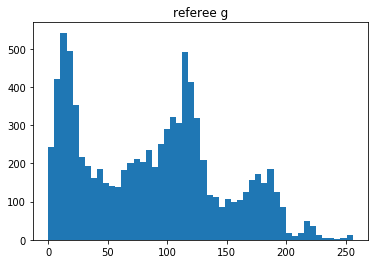

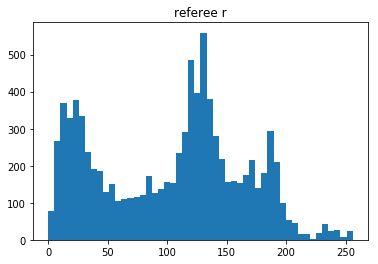

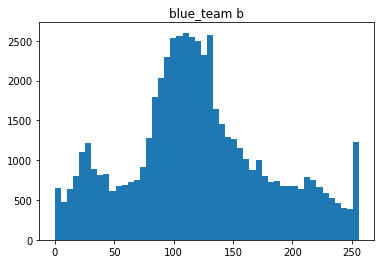

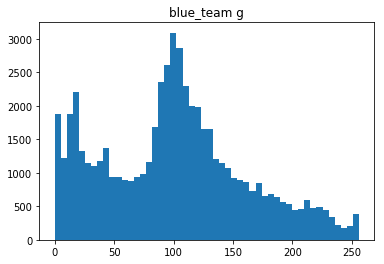

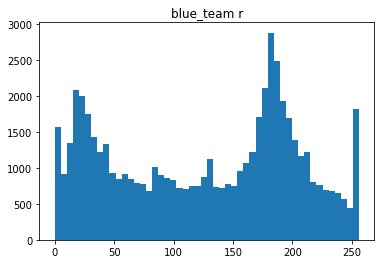

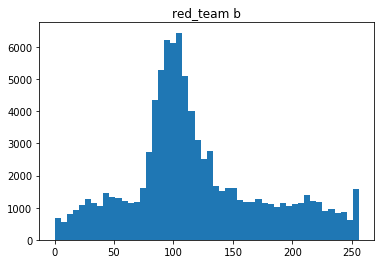

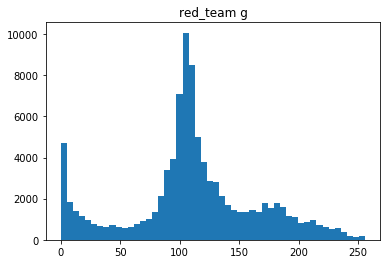

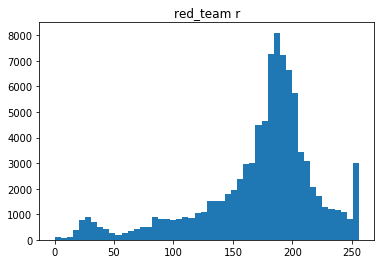

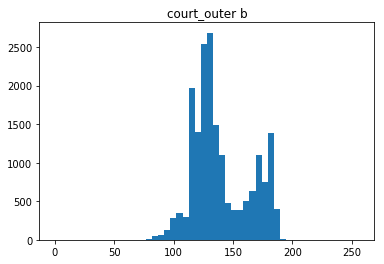

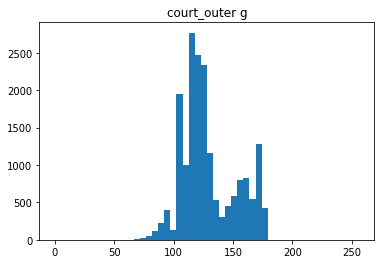

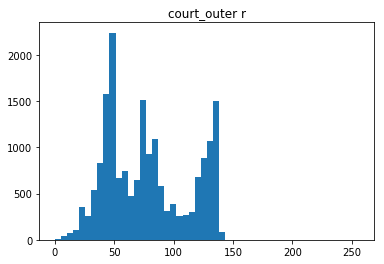

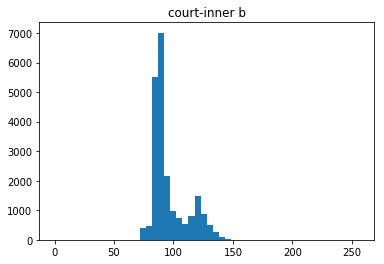

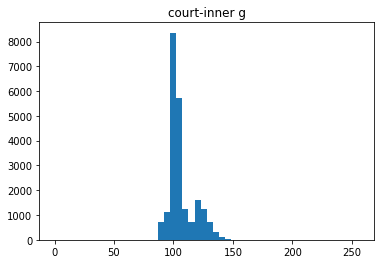

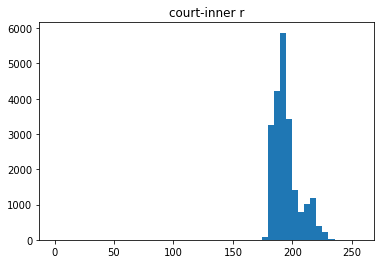

In [80]:
# BGR Histograms
bgr_img = load_cv2_img(img_fpath)
crops = get_img_crops_from_rectLabel_bbs(bgr_img, json_fpath)

hists = {}
for label in crops.keys():
    chans = get_flattened_channels(crops[label])
    bgr = ('b','g','r')
    hists[label] = {
        'b':None,
        'g':None,
        'r':None
    }
    for i in range(len(chans[0])):
        hist, bins = np.histogram(chans[:,i], 50, [0,256])
        hists[label][bgr[i]] = hist
        plot_hist(chans[:,i], bins=50, title=label + ' ' + bgr[i])

### RGB Threshold

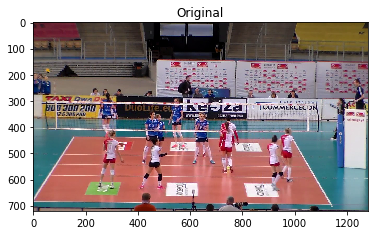

Min [ 165.3   76.    57.8]
Max [ 255.   238.   216.2]


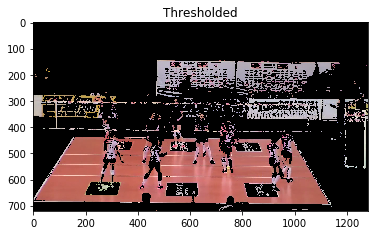

In [81]:
# RGB

img_fpath = os.path.join(IMG_DIR, 'volleyball_frame_00665.png')
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
plot_img(img, title="Original")

r = 175 + 220 // 2
g = 90 + 135 // 2
b = 75 + 125 // 2
color = (
    r,g,b
)
thresh = (
    220 - 175 // 2,
    135 - 90 // 2,
    125 - 75 // 2
)
mask, result = threshold_color(img, color, thresh, sigma=.9)
plot_img(result, title="Thresholded")

Min [0 0 0]
Max [ 11 255 255]


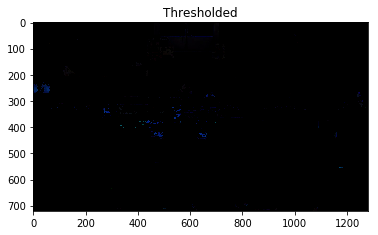

In [82]:
"""
H 0 - 10
S = 100 - 150
V = 175 - 220
"""
color = (
    5,
    50,
    45
)
thresh = (
    6,
    256,
    256
)
mask, result = threshold_color(img, color, thresh, sigma=1)
plot_img(result, title="Thresholded")

## K-Means (Color Quantization)

* Color Quantization is the process of reducing number of colors in an image.
* https://paper.dropbox.com/doc/K-Means-c2mMewAUSX6bgN6TZoPh2
* https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html


In [83]:
def quantize(img, k):
    Z = img.reshape((-1,3)).astype('float32')
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(
        Z, K=k, bestLabels=None, criteria=criteria, attempts=10,
        flags=cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    return res2

img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)

### Gray

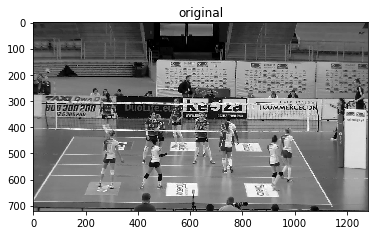

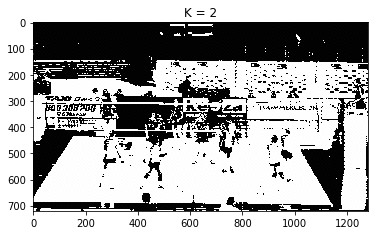

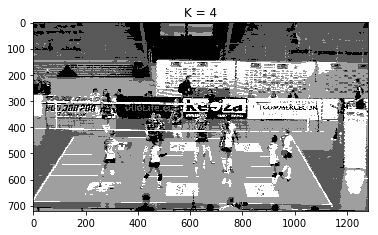

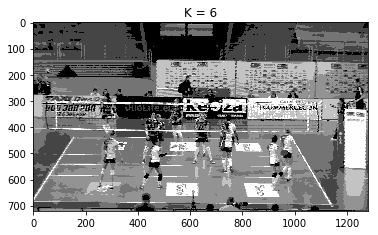

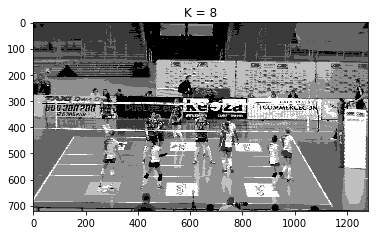

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plot_img(gray, fs=FIGSIZE, title='original')
imgq = quantize(gray, k=2)
plot_img(imgq, fs=FIGSIZE, title="K = 2")
imgq = quantize(gray, k=4)
plot_img(imgq, fs=FIGSIZE, title="K = 4")
imgq = quantize(gray, k=6)
plot_img(imgq, fs=FIGSIZE, title="K = 6")
imgq = quantize(gray, k=8)
plot_img(imgq, fs=FIGSIZE, title="K = 8")

### Color

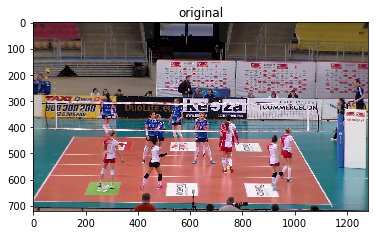

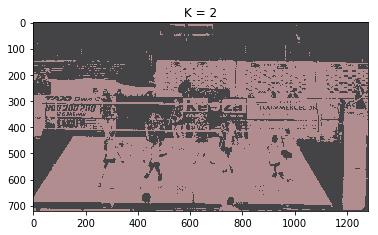

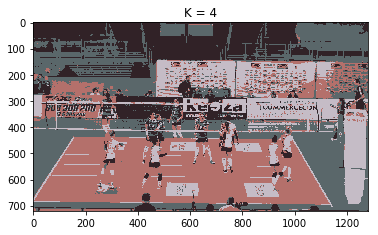

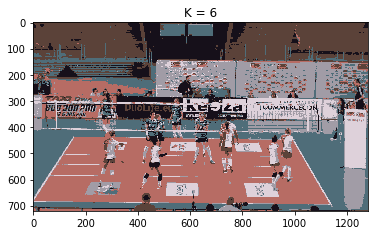

In [ ]:
plot_img(img, fs=FIGSIZE, title='original')
imgq = quantize(img, k=2)
plot_img(imgq, fs=FIGSIZE, title="K = 2")
imgq = quantize(img, k=4)
plot_img(imgq, fs=FIGSIZE, title="K = 4")
imgq = quantize(img, k=6)
plot_img(imgq, fs=FIGSIZE, title="K = 6")
imgq = quantize(img, k=8)
plot_img(imgq, fs=FIGSIZE, title="K = 8")

### Graph Cut

* Foreground segmentation
* Need to pick an object

* https://docs.opencv.org/3.1.0/d8/d83/tutorial_py_grabcut.html
* http://bitsearch.blogspot.com/2014/01/understanding-graph-cuts-for-image.html

## Links